![Alt Text](https://drive.google.com/uc?id=1OdSdnPuhjYY19sq57L-1XqmGvUVXCWle)
 <h1>Pathology Classification in phonocardiograms Using ML</h1>

##Group Members
* Javaria Akhtar
* Hamza Khalil


#Mounting Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
cd /content/drive/MyDrive/ML_semester_project

/content/drive/MyDrive/ML_semester_project


#Dataset Source
### https://physionet.org/content/challenge-2016/1.0.0/

In [ ]:
!wget https://physionet.org/files/challenge-2016/1.0.0/training.zip?download -O /content/training.zip
!wget https://physionet.org/files/challenge-2016/1.0.0/annotations.zip?download -O /content/annotations.zip

--2023-10-12 08:27:38--  https://physionet.org/files/challenge-2016/1.0.0/training.zip?download
Resolving physionet.org (physionet.org)... 18.18.42.54
Connecting to physionet.org (physionet.org)|18.18.42.54|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 190112103 (181M) [application/zip]
Saving to: ‘training.zip?download’

training.zip?downlo 100%[===================>] 181.30M  1.31MB/s    in 2m 20s  

2023-10-12 08:29:59 (1.29 MB/s) - ‘training.zip?download’ saved [190112103/190112103]



#Extracting Dataset

In [ ]:
!unzip training.zip
!unzip annotations.zip

Archive:  annotations.zip
  inflating: annotations/training-b/REFERENCE_withSQI.csv  
  inflating: annotations/training-f/REFERENCE_withSQI.csv  
  inflating: annotations/training-e/REFERENCE_withSQI.csv  
  inflating: annotations/training-d/REFERENCE_withSQI.csv  
  inflating: annotations/training-c/REFERENCE_withSQI.csv  
  inflating: annotations/training-a/REFERENCE_withSQI.csv  


#Installing Library

In [ ]:
!pip install python_speech_features

  Preparing metadata (setup.py) ... done
  Created wheel for python_speech_features: filename=python_speech_features-0.6-py3-none-any.whl size=5870 sha256=4f03d1d6006fc701a30bf15eac8318f744285c4bb0db3129fb7b10fe0c8b9f69
  Stored in directory: /root/.cache/pip/wheels/5a/9e/68/30bad9462b3926c29e315df16b562216d12bdc215f4d240294
Successfully built python_speech_features


#Importing Libraries

### sklearn 1.2.2

In [ ]:
import numpy as np
import pandas as pd
from tqdm import tqdm
import librosa
import librosa.display
import IPython.display as ipd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn import preprocessing
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
import python_speech_features as mf
import os
import matplotlib.pyplot as plt
from IPython.display import Audio
import seaborn as sns
import warnings
from sklearn.metrics import confusion_matrix
import soundfile as sf
import pickle

import joblib

#Defining Variables

In [ ]:
training_dir = 'training/'  # Replace with the actual directory
syn_csv_file_path = 'annotations/training-s/REFERENCE_withSQI.csv'
model_filename = 'trained_model.pkl'

annotations_dir='annotations/'
features_csv = 'features.csv'

#Loading Dataset

In [ ]:


def dataset_loader(folder_names):
    # List to store file paths
    file_paths = []

    for folder in folder_names:
        file_path = os.path.join('annotations', f'training-{folder}', 'REFERENCE_withSQI.csv')
        file_paths.append(file_path)

    # Define the column names.
    column_names = ['file', 'label', 'quality']

    # Initialize an empty DataFrame to store the combined data.
    combined_df = pd.DataFrame(columns=column_names)

    for file_path in file_paths:
        # Use the read_csv function with the specified column names.
        df = pd.read_csv(file_path, names=column_names)

        # Drop rows where quality is equal to 0.
        # df = df[df['quality'] != 0]

        df['label'] = df['label'].astype(int)

        # Append the current dataframe to the combined dataframe.
        combined_df = combined_df.append(df, ignore_index=True)

    return combined_df

# Example usage:
folder_names = ['a', 'b', 'c', 'd', 'e', 'f']
dataset = dataset_loader(folder_names)


<ipython-input-6-e3da0024d052>:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  combined_df = combined_df.append(df, ignore_index=True)
<ipython-input-6-e3da0024d052>:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  combined_df = combined_df.append(df, ignore_index=True)
<ipython-input-6-e3da0024d052>:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  combined_df = combined_df.append(df, ignore_index=True)
<ipython-input-6-e3da0024d052>:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  combined_df = combined_df.append(df, ignore_index=True)
<ipython-input-6-e3da0024d052>:25: FutureWarning: The frame.append method is deprecated and will

#Exploring Dataset
* file: recording name

* label: classification reference (1 for abnormal and -1 for normal)


* quality 3: signal quality reference (0 for unsure and 1 for heart sound recordings could be used for normal/abnormal classification)

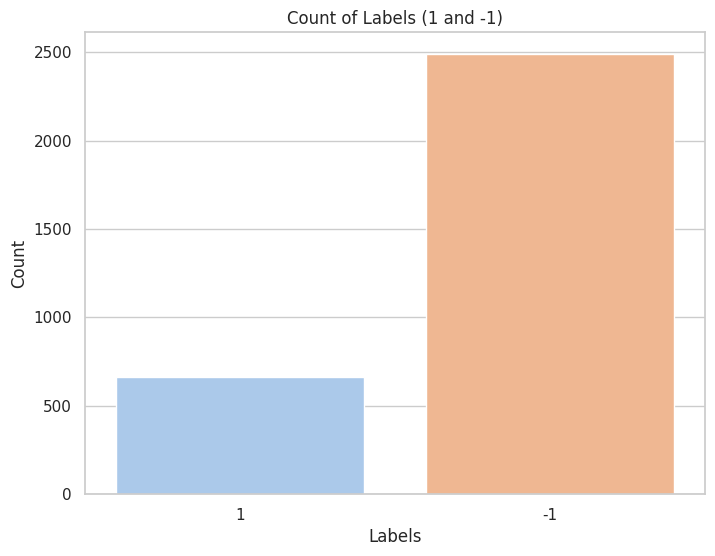

In [ ]:


# Now, 'combined_df' contains the data from all the files with quality not equal to 0.
label_counts = dataset['label'].value_counts()

# Count of '1' and '-1' in labels
count_1 = label_counts.get(1, 0)
count_minus_1 = label_counts.get(-1, 0)

# Create a bar plot using Seaborn
sns.set(style="whitegrid")
plt.figure(figsize=(8, 6))

# Define the data and labels
labels = ['1', '-1']
counts = [count_1, count_minus_1]

# Create the bar plot
sns.barplot(x=labels, y=counts, palette="pastel")

# Adding labels and title
plt.xlabel('Labels')
plt.ylabel('Count')
plt.title('Count of Labels (1 and -1)')

# Show the plot
plt.show()


#Displaying Samples

Normal Sample (Blue):


Abnormal Sample (Red):


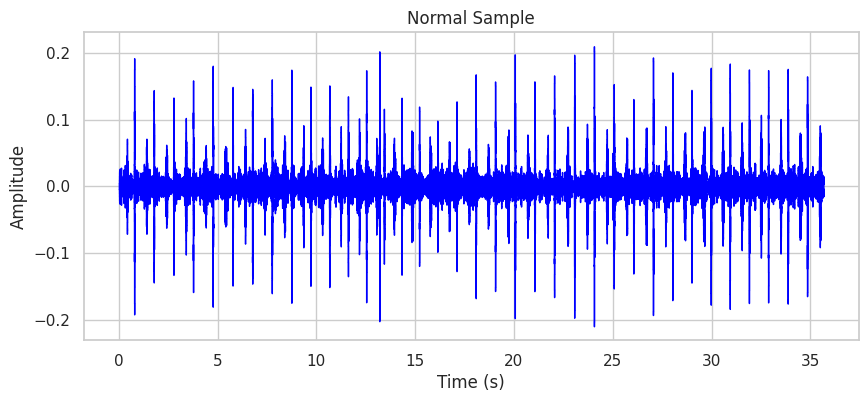

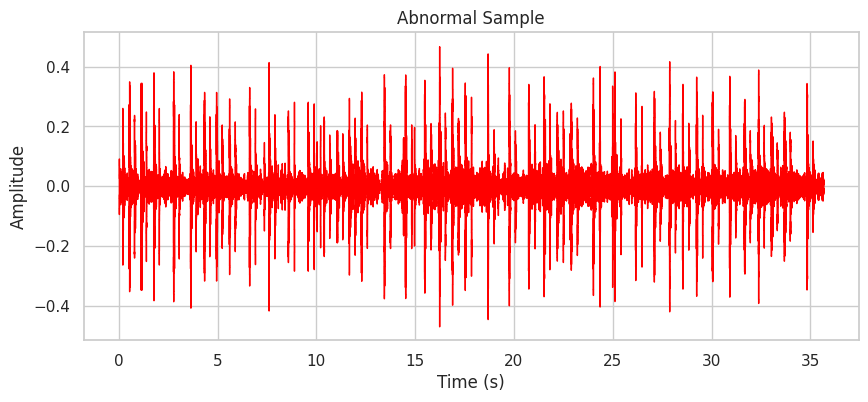

In [ ]:


# Define a function to visualize the waveform and play audio
def visualize_and_play_audio(file_path, title, color):
    # Load the audio file using librosa
    y, sr = librosa.load(file_path, sr=None)

    # Plot the waveform
    plt.figure(figsize=(10, 4))
    librosa.display.waveshow(y, sr=sr, color=color)
    plt.title(title)
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')

    # Play the audio
    display(Audio(file_path))

# Iterate through the DataFrame and select one normal and one abnormal sample
normal_sample = None
abnormal_sample = None

for index, row in dataset.iterrows():
    if row['label'] == 1 and normal_sample is None:
        normal_sample = row['file']
    elif row['label'] == -1 and abnormal_sample is None:
        abnormal_sample = row['file']

    if normal_sample is not None and abnormal_sample is not None:
        break

# Base directory for audio files


# File paths for normal and abnormal samples
normal_file_path = os.path.join(training_dir, f'training-{normal_sample[0]}', f'{normal_sample}.wav')
abnormal_file_path = os.path.join(training_dir, f'training-{abnormal_sample[0]}', f'{abnormal_sample}.wav')

# Visualize and play the normal and abnormal samples
print("Normal Sample (Blue):")
visualize_and_play_audio(normal_file_path, title="Normal Sample", color="blue")

print("Abnormal Sample (Red):")
visualize_and_play_audio(abnormal_file_path, title="Abnormal Sample", color="red")


#Dataset Augmentation
###Creating synthetic/Augmented Data for class 1

In [ ]:


def datagenerator(training_dir, pitch_shift_steps=2, time_stretch_factor=1.2):
    # Define the base directory and create "training-s" directory if it doesn't exist
    output_dir = os.path.join(training_dir, 'training-s')
    csv_dir = os.path.join(training_dir, 'training-s')
    os.makedirs(output_dir, exist_ok=True)
    os.makedirs(csv_dir, exist_ok=True)

    csv_data = []

    # Loop through the dataframe to process the "1" label files
    for index, row in dataset.iterrows():
        if row['label'] == 1:
            file_name = row['file']  # 'a0001' style file name
            folder = file_name[0]  # Extract the folder name (e.g., 'a' from 'a0001')
            folder_path = os.path.join(training_dir, f'training-{folder}')
            file_path = os.path.join(folder_path, f'{file_name}.wav')

            # Ensure the target folder exists in "training-s"
            target_folder_path = output_dir
            os.makedirs(target_folder_path, exist_ok=True)

            print(f"Processing: {file_path}")

            # Load the original audio
            audio, sr = librosa.load(file_path, sr=None)

            # Apply time stretching
            audio_stretched = librosa.effects.time_stretch(audio, rate=time_stretch_factor)

            # Apply pitch shifting separately
            audio_pitch_shifted = librosa.effects.pitch_shift(audio_stretched, sr=sr, n_steps=pitch_shift_steps)

            # Generate the new file name (e.g., 'a0001' -> 's0001')
            new_file_name = 's' + file_name[0:]

            # Save the augmented audio with the new file name in the "training-s" folder
            output_file_path = os.path.join(target_folder_path, f'{new_file_name}.wav')
            sf.write(output_file_path, audio_pitch_shifted, sr)
            csv_data.append({'file': new_file_name, 'label': '1', 'quality': 1})

    new_df = pd.DataFrame(csv_data)

    # Save the DataFrame to a CSV file
    new_df.to_csv(syn_csv_file_path, index=False, header=False)

# Example usage:
# datagenerator(training_dir, pitch_shift_steps=2, time_stretch_factor=1.2)


#Loading Final Dataset
###With Augmentation

In [ ]:
folder_names = ['a', 'b', 'c', 'd', 'e', 'f','s']
dataset = dataset_loader(folder_names)

<ipython-input-6-e3da0024d052>:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  combined_df = combined_df.append(df, ignore_index=True)
<ipython-input-6-e3da0024d052>:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  combined_df = combined_df.append(df, ignore_index=True)
<ipython-input-6-e3da0024d052>:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  combined_df = combined_df.append(df, ignore_index=True)
<ipython-input-6-e3da0024d052>:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  combined_df = combined_df.append(df, ignore_index=True)
<ipython-input-6-e3da0024d052>:25: FutureWarning: The frame.append method is deprecated and will

In [ ]:
dataset = dataset[dataset['quality'] != 0]
dataset = dataset.reset_index(drop=True)
# Convert the 'label' column from object to int in an existing DataFrame
# dataset['label'] = dataset['label'].astype(int)

dataset

,file,label,quality
0,a0001,1,1
1,a0002,1,1
2,a0003,1,1
3,a0004,1,1
4,a0005,1,1
...,...,...,...
3441,sf0090,1,1
3442,sf0093,1,1
3443,sf0096,1,1
3444,sf0099,1,1


In [ ]:

# Now, 'combined_df' contains the data from all the files with quality not equal to 0.
label_counts = dataset['label'].value_counts()

print("Count of '1' in labels:", label_counts.get(1, 0))  # Count of '1' or 0 if not present
print("Count of '-1' in labels:", label_counts.get(-1, 0))  # Count of '-1' or 0 if not present

Count of '1' in labels: 1144
Count of '-1' in labels: 2302


#Resampling

In [ ]:


def filter_and_sample_data(dataset, class_labels=[1, -1], sample_size=1000, random_state=42):
    """
    Filter and sample data from the dataset based on specified class labels and sample size.

    Args:
        dataset (pd.DataFrame): The input DataFrame.
        class_labels (list): A list of class labels to filter.
        sample_size (int): Number of samples to be taken for each class.
        random_state (int): Random seed for reproducibility.

    Returns:
        pd.DataFrame: The new DataFrame containing the sampled data.
    """
    # Filter the data
    filtered_data = dataset[dataset['label'].isin(class_labels)]

    # Set the random seed for reproducibility
    np.random.seed(random_state)

    # Sample the data
    sampled_data = filtered_data.groupby('label').apply(lambda x: x.sample(sample_size))

    # Reset the index
    new_combined_df = sampled_data.reset_index(drop=True)

    return new_combined_df

# Example usage:
dataset = filter_and_sample_data(dataset, class_labels=[1, -1], sample_size=1000, random_state=42)
dataset


,file,label,quality
0,e00610,-1,1
1,e01137,-1,1
2,e01899,-1,1
3,e01008,-1,1
4,e00023,-1,1
...,...,...,...
1995,sc0009,1,1
1996,e00703,1,1
1997,sa0237,1,1
1998,sa0255,1,1


#Fearture Extraction
###Approx 20 mins to run

In [ ]:

def feature_1(file):
    audio,sr = librosa.load(file)
    zcr = librosa.zero_crossings(audio)
    zcr = sum(zcr)
    data = pd.DataFrame([zcr],columns=['A'])
    return data

def feature_2(file):
    audio,sr = librosa.load(file)

    #mfcc=np.mean(librosa.feature.mfcc(audio,sr = sr,n_mfcc=12).T,axis=0)


    mfcc_feature =np.mean(mf.mfcc(audio,sr, 0.025, 0.01,12,nfft = 1200, appendEnergy = True),axis = 0)
    #mfcc_feature = preprocessing.scale(mfcc_feature)
    mfcc = pd.DataFrame(mfcc_feature)
    #df1 = pd.DataFrame(mfcc)
    #df1 = df1.T
    mfcc = mfcc.T
    return mfcc


def feature_3(file):
    try:
        # Load the audio file
        audio, sr = librosa.load(file)

        # Extract chroma feature
        chromagram = np.mean(librosa.feature.chroma_stft(y=audio, sr=sr, hop_length=512),axis=1)

        # Create a DataFrame from the chroma feature
        cr = pd.DataFrame(chromagram)

        cr=cr.T

        return cr
    except Exception as e:
        print(f"Error processing file {file}: {e}")
        return None  # Return None in case of an error





# def process_dataset(dataset, training_dir, feature_1, feature_2, feature_3):
#     # Ignore all warnings
#     warnings.filterwarnings("ignore")

#     data_1 = pd.DataFrame()
#     data_2 = pd.DataFrame()
#     data_3 = pd.DataFrame()
#     total_files = len(dataset)

#     for index, row in dataset.iterrows():
#         file_name = row['file']  # 'a0001' style file name

#         folder = file_name[0]  # Extract the folder name (e.g., 'a' from 'a0001')
#         folder_path = os.path.join(training_dir, f'training-{folder}')
#         file_path = os.path.join(folder_path, f'{file_name}.wav')

#         print(f"Processing file {index + 1}/{total_files}: {file_path}")

#         temp_1 = feature_1(file_path)
#         temp_2 = feature_2(file_path)
#         temp_3 = feature_3(file_path)
#         data_1 = data_1.append(temp_1)
#         data_2 = data_2.append(temp_2)
#         data_3 = data_3.append(temp_3)

#     return data_1, data_2, data_3

# # Example usage:
# data_1, data_2, data_3 = process_dataset(dataset, training_dir, feature_1, feature_2, feature_3)





#Merging Features

In [ ]:
features = pd.concat([ data_1,data_2,data_3], axis=1, ignore_index=True)
features=features.reset_index(drop=True)
# Save the DataFrame as a CSV file
features.to_csv(features_csv, index=False)
features

,0,1,2,3,4,5,6,7,8,9,...,15,16,17,18,19,20,21,22,23,24
0,3785,-7.474458,31.214722,19.717143,9.177936,2.345421,3.419174,12.154207,18.176706,16.953918,...,0.591610,0.612203,0.637988,0.664418,0.621206,0.628024,0.612163,0.624985,0.617917,0.613618
1,3303,-9.297719,34.723247,18.167335,0.768622,-9.020163,-4.712352,10.508305,21.211893,20.198909,...,0.705372,0.728397,0.773250,0.778190,0.719525,0.709692,0.678553,0.677289,0.685672,0.685745
2,9739,-5.367544,29.604378,18.661045,9.019348,2.528656,3.069998,10.848654,16.174246,14.995769,...,0.656434,0.662182,0.641808,0.644038,0.607818,0.610910,0.604031,0.625408,0.612264,0.636463
3,6020,-7.257072,30.147070,19.706936,10.888202,5.093113,5.570441,12.343331,16.231951,13.964398,...,0.595512,0.630558,0.655743,0.690986,0.673674,0.694349,0.684719,0.703269,0.661255,0.646208
4,2274,-8.586589,32.958749,16.300311,-0.297631,-8.990150,-4.090275,10.955296,21.188336,20.175582,...,0.671271,0.692870,0.686604,0.716060,0.755251,0.731246,0.686391,0.683242,0.632124,0.611809
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,2836,-9.789873,23.152673,15.073373,12.346243,10.717663,9.743417,11.345642,11.886786,11.959454,...,0.832026,0.840571,0.844791,0.807431,0.726247,0.688287,0.691211,0.717880,0.745595,0.784792
1996,1097,-6.997591,26.710849,15.623647,6.991329,1.660162,2.766471,10.802468,16.986301,17.742650,...,0.836770,0.856242,0.864727,0.850640,0.774670,0.752586,0.740474,0.731146,0.718060,0.745136
1997,3206,-9.998396,28.837491,16.593786,6.497726,1.362251,4.649460,14.987710,21.228686,19.088570,...,0.783305,0.794504,0.807324,0.745936,0.692503,0.651317,0.629182,0.598529,0.589110,0.630841
1998,3738,-11.129236,30.801229,17.078575,4.302047,-1.834139,3.495849,17.220069,25.105912,21.441964,...,0.658903,0.655113,0.653636,0.681519,0.646845,0.668582,0.678246,0.685934,0.676796,0.705851


#Extracting Labels

In [ ]:
target = dataset['label']
target = pd.DataFrame(target)
target=target.reset_index(drop=True)
target['label'] = target['label'].astype(int)
target

,label
0,-1
1,-1
2,-1
3,-1
4,-1
...,...
1995,1
1996,1
1997,1
1998,1


In [ ]:
features = pd.read_csv('features.csv')
features

,0,1,2,3,4,5,6,7,8,9,...,15,16,17,18,19,20,21,22,23,24
0,3785,-7.474458,31.214722,19.717143,9.177936,2.345421,3.419174,12.154207,18.176706,16.953918,...,0.591610,0.612203,0.637988,0.664418,0.621206,0.628024,0.612163,0.624985,0.617917,0.613618
1,3303,-9.297719,34.723247,18.167335,0.768622,-9.020163,-4.712352,10.508305,21.211893,20.198909,...,0.705372,0.728397,0.773250,0.778190,0.719525,0.709692,0.678553,0.677289,0.685672,0.685745
2,9739,-5.367544,29.604378,18.661045,9.019348,2.528656,3.069998,10.848654,16.174246,14.995769,...,0.656434,0.662182,0.641808,0.644038,0.607818,0.610910,0.604031,0.625408,0.612264,0.636463
3,6020,-7.257072,30.147070,19.706936,10.888202,5.093113,5.570441,12.343331,16.231951,13.964398,...,0.595512,0.630558,0.655743,0.690986,0.673674,0.694349,0.684719,0.703269,0.661255,0.646208
4,2274,-8.586589,32.958749,16.300311,-0.297631,-8.990150,-4.090275,10.955296,21.188336,20.175582,...,0.671271,0.692870,0.686604,0.716060,0.755251,0.731246,0.686391,0.683242,0.632124,0.611809
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,2836,-9.789873,23.152673,15.073373,12.346243,10.717663,9.743417,11.345642,11.886786,11.959454,...,0.832027,0.840571,0.844791,0.807431,0.726247,0.688287,0.691211,0.717880,0.745595,0.784791
1996,1097,-6.997591,26.710849,15.623647,6.991329,1.660162,2.766471,10.802468,16.986301,17.742650,...,0.836770,0.856242,0.864727,0.850640,0.774670,0.752586,0.740474,0.731146,0.718060,0.745136
1997,3206,-9.998396,28.837491,16.593786,6.497726,1.362251,4.649460,14.987710,21.228686,19.088570,...,0.783305,0.794504,0.807324,0.745936,0.692503,0.651317,0.629182,0.598529,0.589110,0.630841
1998,3738,-11.129236,30.801229,17.078575,4.302047,-1.834139,3.495849,17.220069,25.105912,21.441964,...,0.658903,0.655113,0.653636,0.681519,0.646845,0.668582,0.678246,0.685934,0.676796,0.705851


In [ ]:

result_final = pd.concat([features,target], axis=1)
result_final

,0,1,2,3,4,5,6,7,8,9,...,16,17,18,19,20,21,22,23,24,label
0,3785,-7.474458,31.214722,19.717143,9.177936,2.345421,3.419174,12.154207,18.176706,16.953918,...,0.612203,0.637988,0.664418,0.621206,0.628024,0.612163,0.624985,0.617917,0.613618,-1
1,3303,-9.297719,34.723247,18.167335,0.768622,-9.020163,-4.712352,10.508305,21.211893,20.198909,...,0.728397,0.773250,0.778190,0.719525,0.709692,0.678553,0.677289,0.685672,0.685745,-1
2,9739,-5.367544,29.604378,18.661045,9.019348,2.528656,3.069998,10.848654,16.174246,14.995769,...,0.662182,0.641808,0.644038,0.607818,0.610910,0.604031,0.625408,0.612264,0.636463,-1
3,6020,-7.257072,30.147070,19.706936,10.888202,5.093113,5.570441,12.343331,16.231951,13.964398,...,0.630558,0.655743,0.690986,0.673674,0.694349,0.684719,0.703269,0.661255,0.646208,-1
4,2274,-8.586589,32.958749,16.300311,-0.297631,-8.990150,-4.090275,10.955296,21.188336,20.175582,...,0.692870,0.686604,0.716060,0.755251,0.731246,0.686391,0.683242,0.632124,0.611809,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,2836,-9.789873,23.152673,15.073373,12.346243,10.717663,9.743417,11.345642,11.886786,11.959454,...,0.840571,0.844791,0.807431,0.726247,0.688287,0.691211,0.717880,0.745595,0.784791,1
1996,1097,-6.997591,26.710849,15.623647,6.991329,1.660162,2.766471,10.802468,16.986301,17.742650,...,0.856242,0.864727,0.850640,0.774670,0.752586,0.740474,0.731146,0.718060,0.745136,1
1997,3206,-9.998396,28.837491,16.593786,6.497726,1.362251,4.649460,14.987710,21.228686,19.088570,...,0.794504,0.807324,0.745936,0.692503,0.651317,0.629182,0.598529,0.589110,0.630841,1
1998,3738,-11.129236,30.801229,17.078575,4.302047,-1.834139,3.495849,17.220069,25.105912,21.441964,...,0.655113,0.653636,0.681519,0.646845,0.668582,0.678246,0.685934,0.676796,0.705851,1


#Feature Engineering

In [ ]:
from sklearn.feature_selection import mutual_info_classif
# determine the mutual information
mutual_info = mutual_info_classif(features,target)
mutual_info = pd.Series(mutual_info)
mutual_info.index = features.columns
mutual_info.sort_values(ascending=False)

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


8     0.142669
12    0.126171
16    0.101795
17    0.098914
9     0.091677
13    0.088195
14    0.083488
1     0.079480
18    0.078027
24    0.075515
11    0.072429
2     0.063932
15    0.062915
7     0.054210
5     0.047144
20    0.039486
23    0.036223
4     0.031980
21    0.031430
19    0.024050
6     0.022552
0     0.018865
3     0.013987
10    0.012684
22    0.012029
dtype: float64

#Training Model

In [ ]:

x_train,x_test,y_train,y_test = train_test_split(features,target,test_size=0.2,random_state=0)
model =GradientBoostingClassifier()
model.fit(x_train,y_train)



/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


GradientBoostingClassifier()

#Model evaluation

In [ ]:
print('Model score :',model.score(x_test,y_test))

y_pred = model.predict(x_test)




from sklearn.metrics import precision_score, recall_score
precision = precision_score(y_test, y_pred, pos_label=1)
recall = recall_score(y_test, y_pred, pos_label=1)

print("Precision for Class 1:", precision)
print("Recall for Class 1:", recall)


Model score : 0.89
Precision for Class 1: 0.8714285714285714
Recall for Class 1: 0.915


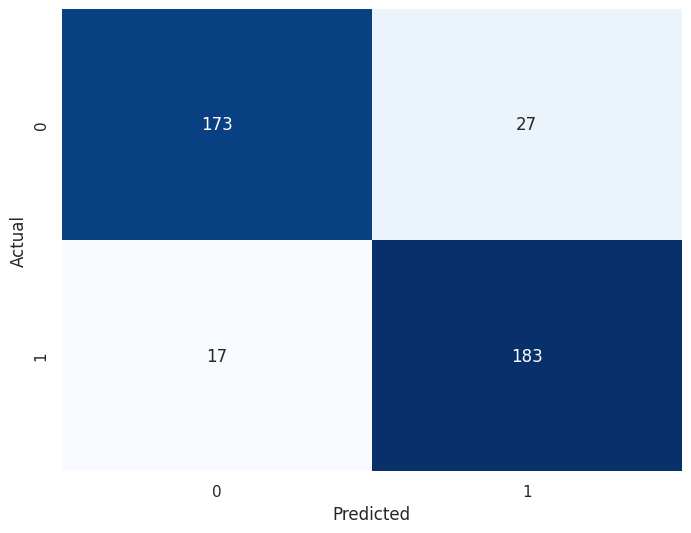

In [ ]:


# Save the model with a .pkl extension
joblib.dump(model, 'model.pkl')

# Load the model from a .pkl file
loaded_model = joblib.load('model.pkl')


# # Make predictions using the loaded model
y_pred = loaded_model.predict(x_test)


# # Compute the confusion matrix
confusion_mat = confusion_matrix(y_test, y_pred)

# # Plot the confusion matrix using Seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_mat, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


#Prediction

In [ ]:


# Define your feature extraction functions (feature_1, feature_2, feature_3) here

# Load the model from the pickle file

loaded_model = joblib.load('model.pkl')

def predict(audio_path):
    # Ignore all warnings
    warnings.filterwarnings("ignore")

    t_1 = feature_1(audio_path)
    t_2 = feature_2(audio_path)
    t_3 = feature_3(audio_path)

    # Concatenate the features horizontally
    extracted_features = pd.concat([t_1, t_2, t_3], axis=1, ignore_index=True)

    # Ensure the shape of the DataFrame is suitable for prediction
    extracted_features = extracted_features.values.reshape(1, -1)


    # Make predictions
    prediction = loaded_model.predict(extracted_features).item()

    if prediction == 1:
        print('Abnormal Heartbeat')
    else:
        print('Normal Heartbeat')

audio_path = '/content/drive/MyDrive/ML_semester_project/training/training-f/f0001.wav'
# Example usage:
predict(audio_path)


Normal Heartbeat
